In [1]:
# VIX Feature Diagnostics - Execute in Jupyter Lab from /src
# This cell contains the complete diagnostic suite

import json,sqlite3,warnings
from collections import defaultdict
from datetime import datetime,timedelta
from pathlib import Path
import numpy as np,pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None);pd.set_option('display.max_rows',100);pd.set_option('display.width',None)
from config import ENSEMBLE_CONFIG
act_thres = .58
class FeatureDiagnostics:
    def __init__(self,feature_data_path='data_cache',db_path='data_cache/predictions.db'):
        self.feature_data_path=Path(feature_data_path);self.db_path=Path(db_path);self.results={};self.features_df=None;self.mag_importance={};self.dir_importance={}
    def load_feature_importance(self,mag_path='data_cache/feature_importance_magnitude.json',dir_path='data_cache/feature_importance_direction.json'):
        print("="*80);print("LOADING FEATURE IMPORTANCE SCORES");print("="*80)
        if Path(mag_path).exists():
            with open(mag_path)as f:self.mag_importance=json.load(f)
            print(f"✓ Loaded {len(self.mag_importance)} magnitude importance scores")
        else:print(f"⚠ Magnitude importance not found at {mag_path}")
        if Path(dir_path).exists():
            with open(dir_path)as f:self.dir_importance=json.load(f)
            print(f"✓ Loaded {len(self.dir_importance)} direction importance scores")
        else:print(f"⚠ Direction importance not found at {dir_path}")
        print()
    def load_latest_features(self):
        print("="*80);print("LOADING FEATURE DATA");print("="*80)
        from core.data_fetcher import UnifiedDataFetcher
        from core.feature_engineer import FeatureEngineer
        fetcher=UnifiedDataFetcher();engineer=FeatureEngineer(data_fetcher=fetcher);yesterday=(datetime.now()-timedelta(days=1)).strftime("%Y-%m-%d");print(f"Building features through {yesterday}...");feature_data=engineer.build_complete_features(years=20,end_date=yesterday,force_historical=False);self.features_df=feature_data['features'];print(f"✓ Loaded {len(self.features_df)} rows × {len(self.features_df.columns)} features");print(f"  Date range: {self.features_df.index[0].date()} → {self.features_df.index[-1].date()}");print();return self.features_df
    def analyze_feature_quality(self):
        print("="*80);print("ANALYZING FEATURE QUALITY");print("="*80);exclude_cols={'vix','spx','calendar_cohort','cohort_weight','feature_quality','spx_lag1'};feature_cols=[c for c in self.features_df.columns if c not in exclude_cols];analysis=[]
        for feat in feature_cols:
            series=self.features_df[feat];total=len(series);valid=series.notna().sum();coverage=(valid/total)*100;nans=series.isna().sum();nan_pct=(nans/total)*100;infs=(np.isinf(series)).sum();inf_pct=(infs/total)*100;zeros=(series==0).sum();zero_pct=(zeros/total)*100;valid_data=series.dropna()
            if len(valid_data)>0:
                unique_vals=valid_data.nunique();unique_pct=(unique_vals/len(valid_data))*100
                # FIX: Convert to float64 before quantile operations to avoid boolean dtype issues
                try:
                    valid_numeric=valid_data.astype(np.float64)
                    val_min=float(valid_numeric.min());val_max=float(valid_numeric.max());val_mean=float(valid_numeric.mean());val_std=float(valid_numeric.std());val_median=float(valid_numeric.median());q25=float(valid_numeric.quantile(0.25));q75=float(valid_numeric.quantile(0.75));iqr=q75-q25;lower_outliers=(valid_numeric<(q25-1.5*iqr)).sum();upper_outliers=(valid_numeric>(q75+1.5*iqr)).sum();outlier_pct=((lower_outliers+upper_outliers)/len(valid_numeric))*100
                    if val_std>0:cv=abs(val_std/val_mean)if val_mean!=0 else np.inf
                    else:cv=0
                except (TypeError, ValueError) as e:
                    # Handle non-numeric columns gracefully
                    val_min=val_max=val_mean=val_std=val_median=q25=q75=np.nan;outlier_pct=0;cv=np.nan
            else:unique_vals=0;unique_pct=0;val_min=np.nan;val_max=np.nan;val_mean=np.nan;val_std=np.nan;val_median=np.nan;outlier_pct=0;cv=np.nan
            mag_imp=self.mag_importance.get(feat,0)*1000;dir_imp=self.dir_importance.get(feat,0)*1000;avg_imp=(mag_imp+dir_imp)/2;imp_rank='NONE'
            if avg_imp>5:imp_rank='HIGH'
            elif avg_imp>2:imp_rank='MEDIUM'
            elif avg_imp>0.1:imp_rank='LOW'
            quality_flag='GOOD';issues=[]
            if coverage<50:quality_flag='CRITICAL';issues.append('LOW_COVERAGE')
            elif coverage<80:quality_flag='POOR';issues.append('MEDIUM_COVERAGE')
            if nan_pct>30:issues.append('HIGH_NAN')
            if inf_pct>1:issues.append('INFINITIES')
            if zero_pct>50:issues.append('HIGH_ZEROS')
            if unique_pct<1:issues.append('LOW_VARIANCE')
            if outlier_pct>10:issues.append('HIGH_OUTLIERS')
            if cv>10:issues.append('HIGH_VOLATILITY')
            if len(issues)>0 and quality_flag=='GOOD':quality_flag='FAIR'
            analysis.append({'feature':feat,'coverage_pct':round(coverage,2),'valid_count':valid,'nan_count':nans,'nan_pct':round(nan_pct,2),'inf_count':infs,'inf_pct':round(inf_pct,4),'zero_count':zeros,'zero_pct':round(zero_pct,2),'unique_values':unique_vals,'unique_pct':round(unique_pct,2),'min':round(val_min,4)if not np.isnan(val_min)else None,'max':round(val_max,4)if not np.isnan(val_max)else None,'mean':round(val_mean,4)if not np.isnan(val_mean)else None,'std':round(val_std,4)if not np.isnan(val_std)else None,'median':round(val_median,4)if not np.isnan(val_median)else None,'q25':round(q25,4)if not np.isnan(q25)else None,'q75':round(q75,4)if not np.isnan(q75)else None,'outlier_pct':round(outlier_pct,2),'coeff_variation':round(cv,4)if not np.isnan(cv)and np.isfinite(cv)else None,'mag_importance':round(mag_imp,4),'dir_importance':round(dir_imp,4),'avg_importance':round(avg_imp,4),'importance_rank':imp_rank,'quality_flag':quality_flag,'issues':'|'.join(issues)if issues else'NONE'})
        self.results['feature_analysis']=pd.DataFrame(analysis);print(f"✓ Analyzed {len(analysis)} features");print(f"  Quality distribution:")
        for qf in['GOOD','FAIR','POOR','CRITICAL']:count=(self.results['feature_analysis']['quality_flag']==qf).sum();print(f"    {qf:10s}: {count:3d}")
        print();return self.results['feature_analysis']
    def identify_problem_features(self):
        print("="*80);print("PROBLEM FEATURE CATEGORIZATION");print("="*80);fa=self.results['feature_analysis'];critical=fa[fa['quality_flag']=='CRITICAL'].sort_values('avg_importance',ascending=False);print(f"\n🔴 CRITICAL ISSUES ({len(critical)} features):");print(f"   Low coverage (<50%) - likely data pipeline problems")
        if len(critical)>0:
            for _,row in critical.head(10).iterrows():print(f"   • {row['feature']:40s} {row['coverage_pct']:5.1f}% coverage | Importance: {row['importance_rank']}")
        poor=fa[fa['quality_flag']=='POOR'].sort_values('avg_importance',ascending=False);print(f"\n🟡 POOR QUALITY ({len(poor)} features):")
        if len(poor)>0:
            for _,row in poor.head(10).iterrows():print(f"   • {row['feature']:40s} {row['coverage_pct']:5.1f}% coverage | Issues: {row['issues']}")
        high_imp_low_cov=fa[(fa['avg_importance']>2)&(fa['coverage_pct']<90)].sort_values('avg_importance',ascending=False);print(f"\n⚠️  HIGH IMPORTANCE + LOW COVERAGE ({len(high_imp_low_cov)} features):");print(f"   These are valuable but need data quality fixes")
        if len(high_imp_low_cov)>0:
            for _,row in high_imp_low_cov.head(10).iterrows():print(f"   • {row['feature']:40s} Imp={row['avg_importance']:6.3f} | Cov={row['coverage_pct']:5.1f}%")
        no_data_no_imp=fa[(fa['coverage_pct']<20)&(fa['avg_importance']<0.1)];print(f"\n💀 NO DATA + NO IMPORTANCE ({len(no_data_no_imp)} features):");print(f"   Deprecation candidates - neither data nor predictive value")
        if len(no_data_no_imp)>0:
            for _,row in no_data_no_imp.head(10).iterrows():print(f"   • {row['feature']:40s} Cov={row['coverage_pct']:5.1f}%")
        self.results['critical_features']=critical;self.results['poor_features']=poor;self.results['high_imp_low_cov']=high_imp_low_cov;self.results['deprecation_candidates']=no_data_no_imp;print()
    def analyze_feature_importance_patterns(self):
        print("="*80);print("FEATURE IMPORTANCE PATTERNS");print("="*80);fa=self.results['feature_analysis'];top_mag=fa.nlargest(20,'mag_importance')[['feature','mag_importance','coverage_pct','quality_flag']];top_dir=fa.nlargest(20,'dir_importance')[['feature','dir_importance','coverage_pct','quality_flag']];print("\n🎯 TOP 20 MAGNITUDE FEATURES:")
        for _,row in top_mag.iterrows():print(f"   {row['feature']:40s} {row['mag_importance']:7.4f} | Cov={row['coverage_pct']:5.1f}% | {row['quality_flag']}")
        print("\n🎯 TOP 20 DIRECTION FEATURES:")
        for _,row in top_dir.iterrows():print(f"   {row['feature']:40s} {row['dir_importance']:7.4f} | Cov={row['coverage_pct']:5.1f}% | {row['quality_flag']}")
        both_high=fa[(fa['mag_importance']>3)&(fa['dir_importance']>3)].sort_values('avg_importance',ascending=False);print(f"\n⭐ HIGH ON BOTH MODELS ({len(both_high)} features):");print("   Universal predictors - consider interactions/derivatives")
        if len(both_high)>0:
            for _,row in both_high.head(15).iterrows():print(f"   • {row['feature']:40s} Mag={row['mag_importance']:6.3f} Dir={row['dir_importance']:6.3f}")
        mag_only=fa[(fa['mag_importance']>3)&(fa['dir_importance']<1)];dir_only=fa[(fa['dir_importance']>3)&(fa['mag_importance']<1)];print(f"\n📊 MAGNITUDE-SPECIFIC ({len(mag_only)} features):")
        if len(mag_only)>0:
            for _,row in mag_only.head(10).iterrows():print(f"   • {row['feature']:40s} Mag={row['mag_importance']:6.3f}")
        print(f"\n📊 DIRECTION-SPECIFIC ({len(dir_only)} features):")
        if len(dir_only)>0:
            for _,row in dir_only.head(10).iterrows():print(f"   • {row['feature']:40s} Dir={row['dir_importance']:6.3f}")
        self.results['top_magnitude']=top_mag;self.results['top_direction']=top_dir;self.results['high_on_both']=both_high;self.results['magnitude_specific']=mag_only;self.results['direction_specific']=dir_only;print()
    def analyze_feature_distributions(self):
        print("="*80);print("DISTRIBUTION ANALYSIS");print("="*80);fa=self.results['feature_analysis'];high_skew=fa[fa['coeff_variation']>5].sort_values('coeff_variation',ascending=False);print(f"\n📈 HIGH VARIABILITY FEATURES ({len(high_skew)}):");print("   Candidates for log transformation or normalization")
        if len(high_skew)>0:
            for _,row in high_skew.head(10).iterrows():print(f"   • {row['feature']:40s} CV={row['coeff_variation']:8.2f} | Imp={row['avg_importance']:6.3f}")
        low_variance=fa[(fa['unique_pct']<5)&(fa['coverage_pct']>90)];print(f"\n🔒 LOW VARIANCE FEATURES ({len(low_variance)}):");print("   Candidates for binarization or binning")
        if len(low_variance)>0:
            for _,row in low_variance.head(10).iterrows():print(f"   • {row['feature']:40s} Unique={row['unique_pct']:5.2f}% | Values={row['unique_values']}")
        self.results['high_variability']=high_skew;self.results['low_variance']=low_variance;print()
    def query_actionable_signals(self):
        print("="*80);print("ACTIONABLE SIGNAL ANALYSIS");print("="*80)
        if not self.db_path.exists():print(f"⚠️  Database not found at {self.db_path}");return None
        conn=sqlite3.connect(self.db_path);query="SELECT forecast_date,observation_date,calendar_cohort,direction_prediction,direction_probability,magnitude_forecast,expected_vix,current_vix,feature_quality,actual_vix_change,direction_correct,magnitude_error FROM forecasts WHERE 1=1 ORDER BY forecast_date DESC";all_preds=pd.read_sql_query(query,conn);all_preds['ensemble_confidence']=all_preds['direction_probability'].apply(lambda x:max(x,1-x)if pd.notna(x)else np.nan);all_preds['actionable']=(all_preds['ensemble_confidence']>=act_thres);actionable=all_preds[all_preds['actionable']==True];print(f"\n📊 SIGNAL OVERVIEW:");print(f"   Total predictions: {len(all_preds)}");print(f"   Actionable: (≥{act_thres} confidence): {len(actionable)} ({len(actionable)/len(all_preds)*100:.1f}%)")
        if len(actionable)>0:
            print(f"\n🎯 ACTIONABLE SIGNAL BREAKDOWN:");print(f"   By Direction:")
            for dir in['UP','DOWN']:count=(actionable['direction_prediction']==dir).sum();print(f"      {dir:4s}: {count:4d} ({count/len(actionable)*100:.1f}%)")
            print(f"\n   By Cohort:")
            for cohort in actionable['calendar_cohort'].value_counts().head(4).index:count=(actionable['calendar_cohort']==cohort).sum();print(f"      {cohort:15s}: {count:4d}")
            print(f"\n   Confidence Distribution:");bins=[0.60,0.65,0.70,0.75,1.0];labels=['60-65%','65-70%','70-75%','75-100%'];actionable['conf_bucket']=pd.cut(actionable['ensemble_confidence'],bins=bins,labels=labels)
            for bucket in labels:count=(actionable['conf_bucket']==bucket).sum();print(f"      {bucket:10s}: {count:4d}")
        with_actuals=all_preds[all_preds['actual_vix_change'].notna()];actionable_actual=with_actuals[with_actuals['actionable']==True]
        if len(actionable_actual)>0:
            print(f"\n✅ ACTIONABLE SIGNAL PERFORMANCE:");print(f"   Signals with actuals: {len(actionable_actual)}");dir_acc=(actionable_actual['direction_correct']==1).sum()/len(actionable_actual);print(f"   Direction accuracy: {dir_acc:.1%}");mag_mae=actionable_actual['magnitude_error'].mean();print(f"   Magnitude MAE: {mag_mae:.2f}%");up_signals=actionable_actual[actionable_actual['direction_prediction']=='UP'];down_signals=actionable_actual[actionable_actual['direction_prediction']=='DOWN']
            if len(up_signals)>0:up_acc=(up_signals['direction_correct']==1).sum()/len(up_signals);print(f"   UP signals accuracy: {up_acc:.1%} ({len(up_signals)} signals)")
            if len(down_signals)>0:down_acc=(down_signals['direction_correct']==1).sum()/len(down_signals);print(f"   DOWN signals accuracy: {down_acc:.1%} ({len(down_signals)} signals)")
        conn.close();self.results['all_predictions']=all_preds;self.results['actionable_signals']=actionable;self.results['actionable_with_actuals']=actionable_actual if len(actionable_actual)>0 else None;print()
    def generate_feature_interaction_candidates(self):
        print("="*80);print("FEATURE INTERACTION OPPORTUNITIES");print("="*80);fa=self.results['feature_analysis'];high_importance=fa[fa['avg_importance']>3].sort_values('avg_importance',ascending=False);vix_features=[f for f in high_importance['feature']if'vix'in f.lower()];spx_features=[f for f in high_importance['feature']if'spx'in f.lower()];regime_features=[f for f in high_importance['feature']if'regime'in f.lower()];vol_features=[f for f in high_importance['feature']if'vol'in f.lower()and'vix'not in f.lower()];print(f"\n🔗 POTENTIAL INTERACTION PAIRS:");print(f"\n   VIX × SPX Interactions:")
        for vf in vix_features[:5]:
            for sf in spx_features[:3]:print(f"      • {vf} × {sf}");print(f"        → ratio: {vf}_over_{sf}");print(f"        → spread: {vf}_minus_{sf}")
        print(f"\n   Regime-Conditional Features:")
        for rf in regime_features[:3]:
            for hf in high_importance['feature'][:5]:
                if'regime'not in hf:print(f"      • {hf} | conditioned_on | {rf}")
        print(f"\n   Volatility Cross-Products:")
        if len(vol_features)>1:
            for i,vf1 in enumerate(vol_features[:4]):
                for vf2 in vol_features[i+1:5]:print(f"      • {vf1} × {vf2}")
        interactions={'vix_spx_pairs':[(v,s)for v in vix_features[:5]for s in spx_features[:3]],'regime_conditionals':[(r,h)for r in regime_features[:3]for h in high_importance['feature'][:5]if'regime'not in h],'vol_cross_products':[(vol_features[i],vol_features[j])for i in range(min(4,len(vol_features)))for j in range(i+1,min(5,len(vol_features)))]};self.results['interaction_candidates']=interactions;print()
    def save_results(self,output_dir='diagnostics'):
        print("="*80);print("SAVING RESULTS");print("="*80);out=Path(output_dir);out.mkdir(exist_ok=True);timestamp=datetime.now().strftime("%Y%m%d_%H%M%S")
        if'feature_analysis'in self.results:csv_path=out/f'feature_analysis_{timestamp}.csv';self.results['feature_analysis'].to_csv(csv_path,index=False);print(f"✓ Saved: {csv_path}")
        if'actionable_signals'in self.results:csv_path=out/f'actionable_signals_{timestamp}.csv';self.results['actionable_signals'].to_csv(csv_path,index=False);print(f"✓ Saved: {csv_path}")
        summary={'timestamp':timestamp,'total_features':len(self.results.get('feature_analysis',[])),'critical_issues':len(self.results.get('critical_features',[])),'poor_quality':len(self.results.get('poor_features',[])),'deprecation_candidates':len(self.results.get('deprecation_candidates',[])),'high_on_both':len(self.results.get('high_on_both',[])),'total_predictions':len(self.results.get('all_predictions',[])),'actionable_signals':len(self.results.get('actionable_signals',[]))};summary_path=out/f'summary_{timestamp}.json'
        with open(summary_path,'w')as f:json.dump(summary,f,indent=2)
        print(f"✓ Saved: {summary_path}");print()
    def generate_visualizations(self,output_dir='diagnostics'):
        print("="*80);print("GENERATING VISUALIZATIONS");print("="*80);out=Path(output_dir);out.mkdir(exist_ok=True);timestamp=datetime.now().strftime("%Y%m%d_%H%M%S");fa=self.results.get('feature_analysis')
        if fa is None:return
        fig,axes=plt.subplots(2,3,figsize=(18,10));fig.suptitle('Feature Quality Diagnostics',fontsize=16,fontweight='bold');ax=axes[0,0];fa['quality_flag'].value_counts().plot(kind='bar',ax=ax,color=['green','yellow','orange','red']);ax.set_title('Quality Distribution');ax.set_xlabel('Quality Flag');ax.set_ylabel('Count');ax=axes[0,1];ax.scatter(fa['coverage_pct'],fa['avg_importance'],alpha=0.5);ax.set_xlabel('Coverage %');ax.set_ylabel('Avg Importance');ax.set_title('Coverage vs Importance');ax.axvline(80,color='red',linestyle='--',alpha=0.5);ax.axhline(2,color='red',linestyle='--',alpha=0.5);ax=axes[0,2];top20=fa.nlargest(20,'avg_importance');ax.barh(range(20),top20['avg_importance']);ax.set_yticks(range(20));ax.set_yticklabels(top20['feature'],fontsize=7);ax.set_title('Top 20 Features by Importance');ax.invert_yaxis();ax=axes[1,0];ax.scatter(fa['mag_importance'],fa['dir_importance'],alpha=0.5);ax.set_xlabel('Magnitude Importance');ax.set_ylabel('Direction Importance');ax.set_title('Magnitude vs Direction Importance');ax.plot([0,fa['mag_importance'].max()],[0,fa['mag_importance'].max()],'r--',alpha=0.3);ax=axes[1,1];ax.hist(fa['coverage_pct'],bins=50,alpha=0.7,edgecolor='black');ax.set_xlabel('Coverage %');ax.set_ylabel('Count');ax.set_title('Coverage Distribution');ax.axvline(80,color='red',linestyle='--');ax=axes[1,2];issue_counts=fa['issues'].str.split('|',expand=True).stack().value_counts();issue_counts=issue_counts[issue_counts.index!='NONE']
        if len(issue_counts)>0:issue_counts.plot(kind='barh',ax=ax);ax.set_title('Common Issues');ax.set_xlabel('Count')
        plt.tight_layout();plot_path=out/f'feature_diagnostics_{timestamp}.png';plt.savefig(plot_path,dpi=150,bbox_inches='tight');plt.close();print(f"✓ Saved: {plot_path}");print()

# EXECUTE DIAGNOSTICS
print("\n"+"="*80);print("VIX FORECASTING SYSTEM - COMPREHENSIVE FEATURE DIAGNOSTICS");print("="*80+"\n")
diag=FeatureDiagnostics()
diag.load_feature_importance()
diag.load_latest_features()
diag.analyze_feature_quality()
diag.identify_problem_features()
diag.analyze_feature_importance_patterns()
diag.analyze_feature_distributions()
diag.query_actionable_signals()
diag.generate_feature_interaction_candidates()
diag.save_results()
diag.generate_visualizations()
print("\n"+"="*80);print("✅ DIAGNOSTICS COMPLETE");print("="*80)
print("\nKey Outputs:");print("  • diagnostics/feature_analysis_*.csv - Full feature metrics");print("  • diagnostics/actionable_signals_*.csv - High-confidence forecasts");print("  • diagnostics/summary_*.json - Executive summary");print("  • diagnostics/feature_diagnostics_*.png - Visualizations")
print("\nNext Steps:");print("  1. Review critical_features and poor_features for data pipeline fixes");print("  2. Examine high_imp_low_cov for important features needing better data");print("  3. Consider deprecating no_data_no_imp features");print("  4. Explore interaction_candidates for synthetic feature engineering");print("  5. Test alternative transformations on high_variability features")

# Access results via: diag.results['feature_analysis'], diag.results['actionable_signals'], etc.


VIX FORECASTING SYSTEM - COMPREHENSIVE FEATURE DIAGNOSTICS

LOADING FEATURE IMPORTANCE SCORES
⚠ Magnitude importance not found at data_cache/feature_importance_magnitude.json
⚠ Direction importance not found at data_cache/feature_importance_direction.json

LOADING FEATURE DATA
Building features through 2025-12-03...

🏗️  Building 20y feature set | Temporal Safety: ON
Mode: RECENT
Date Ranges: Warmup Start -> Warmup End (usable period) -> Training End Date: 2004-09-14 → 2005-12-08 → 2025-12-03
   → Building VX futures features from cached contracts...
   → Building VX futures from cache
   ✓ Loaded 6 contracts
   ✓ Loaded 6 continuous contracts
   → Generating term structure features...
   → Generating positioning features...
   → Generating roll characteristics...
   → Generating regime indicators...
   ✓ Generated 21 VX features | Coverage: 5342 days
⚠️  Replaced sparse Yahoo 2Y (20.2% coverage) with FRED DGS2

✅ Complete: 331 features | 5342 rows
   Date range: 2004-09-13 → 2025-12-

/var/folders/x7/wx6vsrv14yb8t8zyw52zj5r80000gn/T/ipykernel_50497/1512241713.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_data = yf.download("^VIX", start="1990-01-01", end=datetime.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

Fetching VIX data...
REGIME-DEPENDENT STATISTICS FOR VIX

1. REGIME TRANSITION MATRIX (5-day forward)
--------------------------------------------------------------------------------


regime_5d_ahead  Crisis  Elevated  Low Vol  Normal
regime                                            
Crisis            72.09     27.91     0.00    0.00
Elevated           3.40     73.20     0.26   23.14
Low Vol            0.02      0.49    87.26   12.22
Normal             0.22     10.27    15.87   73.65

Interpretation: Shows probability of moving from one regime to another in 5 days

2. MEAN REVERSION STATISTICS BY REGIME
--------------------------------------------------------------------------------

Low Vol:
  Mean 5d return: 2.331%
  Median 5d return: 0.990%
  Std Dev: 12.391%
  % Positive: 54.1%
  % Negative: 45.6%
  >> MOMENTUM (tends to increase)

Normal:
  Mean 5d return: -0.813%
  Median 5d return: -1.750%
  Std Dev: 13.158%
  % Positive: 43.5%
  % Negative: 56.4%

Elevated:
  Mean 5d return: -3.475%
  Median 5d return: -3.787%
  Std Dev: 14.130%
  % Positive: 38.0%
  % Negative: 61.8%
  >> STRONG MEAN REVERSION (tends to decrease)

Crisis:
  Mean 5d return: -6.487%
  Median

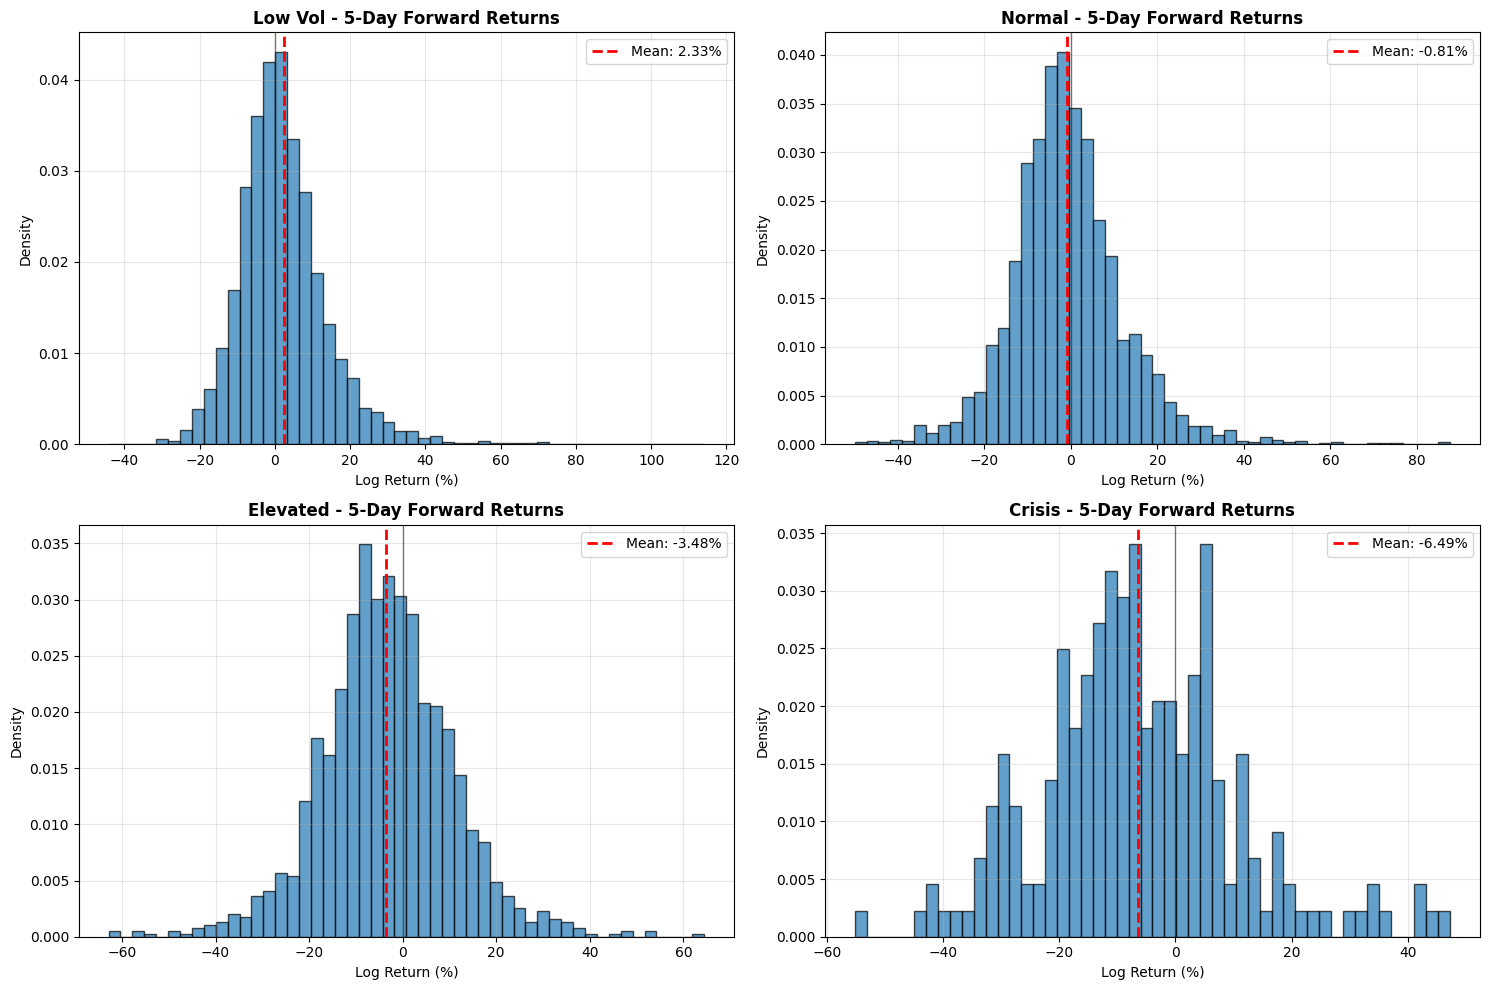


RECOMMENDED FEATURES FOR YOUR XGBOOST MODEL

REGIME-BASED FEATURES:
1. Current regime (categorical)
2. Days in current regime (persistence)
3. Distance to nearest regime boundary
4. VIX percentile rank within current regime
5. Regime transition probability (from transition matrix)

STATISTICAL FEATURES BY REGIME:
6. Rolling volatility of VIX (20d, calibrated by regime)
7. Mean reversion z-score within regime
8. Skewness of recent returns (5d, 20d) - varies by regime
9. Distance from regime mean/median

INTERACTION FEATURES:
10. Regime × Day-of-week
11. Regime × FOMC week indicator
12. Regime × OpEx week indicator
13. Regime × Earnings season indicator
14. Regime × Time-to-FOMC (days)

VOLATILITY CLUSTERING:
15. Vol-of-vol (20-day rolling std of daily VIX changes)
16. GARCH(1,1) conditional variance estimates by regime
17. High-low range percentile within regime

TERM STRUCTURE (if available):
18. VIX/VIX3M ratio
19. VIX/VIX6M ratio
20. Term structure slope change

MEAN REVERSION INDIC

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from scipy import stats
from scipy.stats import skew, kurtosis

# Fetch VIX data
print("Fetching VIX data...")
vix_data = yf.download("^VIX", start="1990-01-01", end=datetime.today().strftime('%Y-%m-%d'))
vix = vix_data['Close'].squeeze().dropna()

# Calculate 5-day forward returns (your target)
vix_forward_5d = vix.shift(-5)
vix_return_5d = np.log(vix_forward_5d / vix) * 100  # log normalized % change

print("="*80)
print("REGIME-DEPENDENT STATISTICS FOR VIX")
print("="*80)

# Define regimes
def assign_regime(value):
    if value < 16.77:
        return 'Low Vol'
    elif value < 24.40:
        return 'Normal'
    elif value < 39.67:
        return 'Elevated'
    else:
        return 'Crisis'

vix_df = pd.DataFrame({
    'vix': vix,
    'regime': vix.apply(assign_regime),
    'forward_5d_return': vix_return_5d
})

# 1. REGIME TRANSITION PROBABILITIES
print("\n1. REGIME TRANSITION MATRIX (5-day forward)")
print("-"*80)
vix_df['regime_5d_ahead'] = vix_df['regime'].shift(-5)
transition_matrix = pd.crosstab(
    vix_df['regime'], 
    vix_df['regime_5d_ahead'], 
    normalize='index'
) * 100
print(transition_matrix.round(2))
print("\nInterpretation: Shows probability of moving from one regime to another in 5 days")

# 2. MEAN REVERSION BY REGIME
print("\n2. MEAN REVERSION STATISTICS BY REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_data = vix_df[vix_df['regime'] == regime]['forward_5d_return'].dropna()
    if len(regime_data) > 0:
        print(f"\n{regime}:")
        print(f"  Mean 5d return: {regime_data.mean():.3f}%")
        print(f"  Median 5d return: {regime_data.median():.3f}%")
        print(f"  Std Dev: {regime_data.std():.3f}%")
        print(f"  % Positive: {(regime_data > 0).sum() / len(regime_data) * 100:.1f}%")
        print(f"  % Negative: {(regime_data < 0).sum() / len(regime_data) * 100:.1f}%")
        
        # Mean reversion indicator
        if regime_data.mean() < -1:
            print(f"  >> STRONG MEAN REVERSION (tends to decrease)")
        elif regime_data.mean() > 1:
            print(f"  >> MOMENTUM (tends to increase)")

# 3. VOLATILITY OF VOLATILITY (vol clustering)
print("\n3. VOLATILITY OF VOLATILITY BY REGIME")
print("-"*80)
vix_df['vix_pct_change'] = vix.pct_change() * 100
vix_df['vol_of_vol_20d'] = vix_df['vix_pct_change'].rolling(20).std()

for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_vol = vix_df[vix_df['regime'] == regime]['vol_of_vol_20d'].dropna()
    if len(regime_vol) > 0:
        print(f"{regime}: Mean Vol-of-Vol = {regime_vol.mean():.2f}, Median = {regime_vol.median():.2f}")

# 4. DISTANCE FROM REGIME BOUNDARIES (key feature!)
print("\n4. DISTANCE FROM REGIME BOUNDARIES")
print("-"*80)
print("Feature idea: How close is VIX to transitioning to next regime?")

def distance_to_boundaries(value):
    boundaries = [16.77, 24.40, 39.67]
    distances = {
        'dist_to_normal': abs(value - 16.77),
        'dist_to_elevated': abs(value - 24.40),
        'dist_to_crisis': abs(value - 39.67),
        'min_boundary_dist': min(abs(value - b) for b in boundaries)
    }
    return distances

sample_vix = [12, 16, 20, 28, 45]
for v in sample_vix:
    dist = distance_to_boundaries(v)
    print(f"VIX={v}: Min distance to boundary = {dist['min_boundary_dist']:.2f}")

# 5. REGIME DURATION STATISTICS
print("\n5. REGIME PERSISTENCE (How long do regimes last?)")
print("-"*80)
vix_df['regime_change'] = vix_df['regime'] != vix_df['regime'].shift(1)
vix_df['regime_duration'] = vix_df.groupby((vix_df['regime_change']).cumsum()).cumcount() + 1

for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    # Get duration at regime exit points
    regime_exits = vix_df[(vix_df['regime'] == regime) & (vix_df['regime_change'].shift(-1) == True)]
    if len(regime_exits) > 0:
        durations = regime_exits['regime_duration']
        print(f"\n{regime}:")
        print(f"  Median duration: {durations.median():.0f} days")
        print(f"  Mean duration: {durations.mean():.0f} days")
        print(f"  Max duration: {durations.max():.0f} days")

# 6. SKEWNESS AND KURTOSIS BY REGIME
print("\n6. DISTRIBUTION CHARACTERISTICS BY REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_returns = vix_df[vix_df['regime'] == regime]['forward_5d_return'].dropna()
    if len(regime_returns) > 10:
        print(f"\n{regime}:")
        print(f"  Skewness: {skew(regime_returns):.3f}")
        print(f"  Kurtosis: {kurtosis(regime_returns):.3f}")
        print(f"  95th percentile: {np.percentile(regime_returns, 95):.2f}%")
        print(f"  5th percentile: {np.percentile(regime_returns, 5):.2f}%")

# 7. VIX SPIKE PROBABILITY
print("\n7. VIX SPIKE ANALYSIS (>20% increase in 5 days)")
print("-"*80)
vix_df['spike'] = vix_df['forward_5d_return'] > 20
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_data = vix_df[vix_df['regime'] == regime]
    if len(regime_data) > 0:
        spike_prob = regime_data['spike'].sum() / len(regime_data) * 100
        print(f"{regime}: {spike_prob:.2f}% chance of >20% spike in next 5 days")

# 8. VIX TERM STRUCTURE FEATURES (if you have VIX futures data)
print("\n8. CONTANGO/BACKWARDATION INDICATORS")
print("-"*80)
print("Recommended features if you have VIX futures:")
print("  - VIX/VIX3M ratio (term structure slope)")
print("  - VIX/VVIX ratio (volatility of volatility)")
print("  - VIX percentile rank within current regime")

# 9. PERCENTILE RANK WITHIN REGIME
print("\n9. VIX PERCENTILE RANK WITHIN CURRENT REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_vix = vix[vix_df['regime'] == regime]
    if len(regime_vix) > 0:
        print(f"\n{regime} range: {regime_vix.min():.2f} - {regime_vix.max():.2f}")
        print(f"  25th percentile: {regime_vix.quantile(0.25):.2f}")
        print(f"  75th percentile: {regime_vix.quantile(0.75):.2f}")
        print(f"  >> Feature: (current_vix - regime_min) / (regime_max - regime_min)")

# 10. AUTOCORRELATION BY REGIME
print("\n10. AUTOCORRELATION STRUCTURE BY REGIME")
print("-"*80)
for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_returns = vix_df[vix_df['regime'] == regime]['vix_pct_change'].dropna()
    if len(regime_returns) > 20:
        acf_1 = regime_returns.autocorr(lag=1)
        acf_5 = regime_returns.autocorr(lag=5)
        print(f"{regime}: ACF(1)={acf_1:.3f}, ACF(5)={acf_5:.3f}")

# 11. REALIZED VOLATILITY VS IMPLIED (VIX)
print("\n11. REALIZED VS IMPLIED VOLATILITY GAP")
print("-"*80)
vix_df['realized_vol_20d'] = vix_df['vix_pct_change'].rolling(20).std() * np.sqrt(252)
vix_df['vix_premium'] = vix_df['vix'] - vix_df['realized_vol_20d']

for regime in ['Low Vol', 'Normal', 'Elevated', 'Crisis']:
    regime_premium = vix_df[vix_df['regime'] == regime]['vix_premium'].dropna()
    if len(regime_premium) > 0:
        print(f"{regime}: Mean VIX premium = {regime_premium.mean():.2f}")

# VISUALIZATION: Regime-dependent return distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
regimes = ['Low Vol', 'Normal', 'Elevated', 'Crisis']

for idx, (regime, ax) in enumerate(zip(regimes, axes.flatten())):
    regime_returns = vix_df[vix_df['regime'] == regime]['forward_5d_return'].dropna()
    
    if len(regime_returns) > 10:
        ax.hist(regime_returns, bins=50, alpha=0.7, edgecolor='black', density=True)
        ax.axvline(regime_returns.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {regime_returns.mean():.2f}%')
        ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_title(f'{regime} - 5-Day Forward Returns', fontsize=12, fontweight='bold')
        ax.set_xlabel('Log Return (%)')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# FEATURE ENGINEERING RECOMMENDATIONS
print("\n" + "="*80)
print("RECOMMENDED FEATURES FOR YOUR XGBOOST MODEL")
print("="*80)
print("""
REGIME-BASED FEATURES:
1. Current regime (categorical)
2. Days in current regime (persistence)
3. Distance to nearest regime boundary
4. VIX percentile rank within current regime
5. Regime transition probability (from transition matrix)

STATISTICAL FEATURES BY REGIME:
6. Rolling volatility of VIX (20d, calibrated by regime)
7. Mean reversion z-score within regime
8. Skewness of recent returns (5d, 20d) - varies by regime
9. Distance from regime mean/median

INTERACTION FEATURES:
10. Regime × Day-of-week
11. Regime × FOMC week indicator
12. Regime × OpEx week indicator
13. Regime × Earnings season indicator
14. Regime × Time-to-FOMC (days)

VOLATILITY CLUSTERING:
15. Vol-of-vol (20-day rolling std of daily VIX changes)
16. GARCH(1,1) conditional variance estimates by regime
17. High-low range percentile within regime

TERM STRUCTURE (if available):
18. VIX/VIX3M ratio
19. VIX/VIX6M ratio
20. Term structure slope change

MEAN REVERSION INDICATORS:
21. (VIX - regime MA) / regime StdDev
22. Days since regime peak/trough
23. Regime momentum (5d return within regime context)

CALENDAR ANOMALIES INTERACTED WITH REGIME:
24. Is Monday × Regime
25. Is Friday × Regime
26. Days to month-end × Regime
27. Quarter-end week × Regime
""")

print("\nKEY INSIGHT: Your model should learn that:")
print("  - Low Vol → High spike probability, mean reversion upward")
print("  - Crisis → High reversion probability, mean reversion downward")
print("  - Regime boundaries are sticky (clustering)")
print("  - Volatility clustering is regime-dependent")

In [34]:
from config import ENSEMBLE_CONFIG
act_thres =ENSEMBLE_CONFIG['actionable_threshold']
print(act_thres)

0.65


Fetching SKEW data...


/var/folders/x7/wx6vsrv14yb8t8zyw52zj5r80000gn/T/ipykernel_6326/2882852012.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  skew_data = yf.download("^SKEW", start="1990-01-01", end=datetime.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


REGIME-DEPENDENT STATISTICS FOR SKEW INDEX
Data range: 1990-01-02 to 2025-12-03
Total observations: 8974
Historical mean: 122.65
Historical median: 119.61
Historical std: 11.32

1. REGIME TRANSITION MATRIX (5-day forward)
--------------------------------------------------------------------------------
regime_5d_ahead  Elevated Tail  Extreme Tail  Low Tail Risk  Normal
regime                                                             
Elevated Tail            48.39         18.73           1.24   31.64
Extreme Tail             28.60         66.13           0.00    5.27
Low Tail Risk             0.11          0.02          85.40   14.47
Normal                    9.04          0.56          22.16   68.23

2. MEAN REVERSION STATISTICS BY REGIME
--------------------------------------------------------------------------------

Low Tail Risk:
  Mean 5d return: 0.683%
  Median 5d return: 0.463%
  Std Dev: 2.838%
  % Positive: 57.7%
  % Negative: 42.1%
  >> MOMENTUM (tends to increase)

Normal:

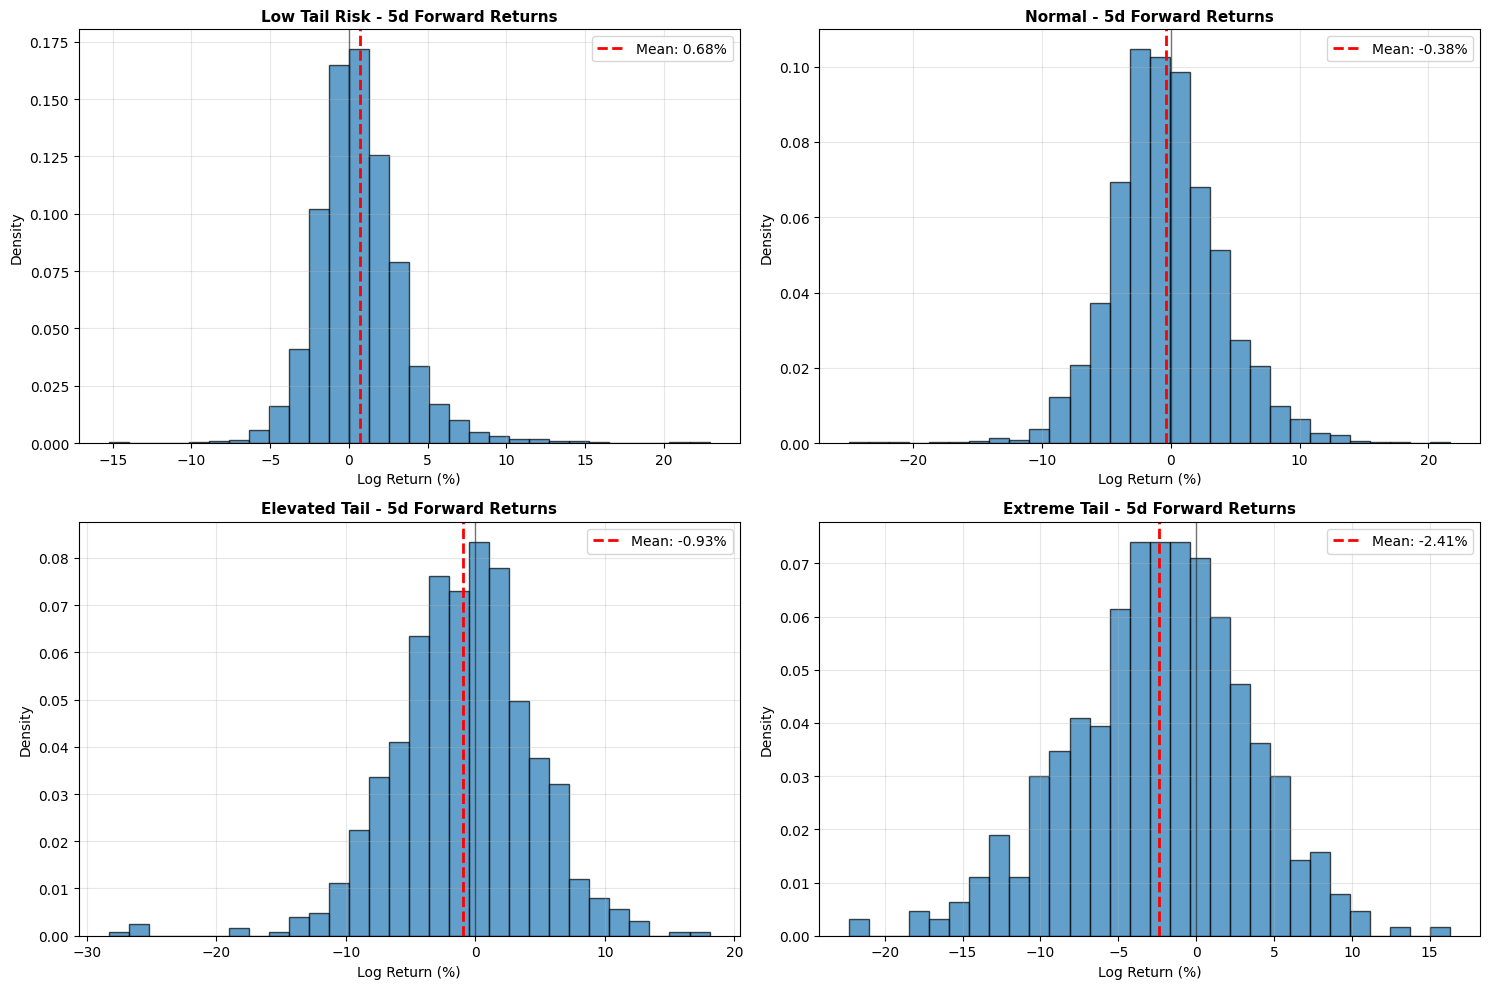


RECOMMENDED FEATURES FOR SKEW MODELING

REGIME-BASED:
1. Current regime (categorical)
2. Days in current regime
3. Distance to regime boundaries
4. SKEW percentile within regime
5. Regime transition probability

STATISTICAL:
6. Rolling volatility (20d)
7. Mean reversion z-score within regime
8. Distance from regime mean/median
9. 5d/20d momentum within regime context

INTERACTION WITH VIX:
10. SKEW × VIX regime interaction
11. SKEW - VIX spread
12. (SKEW - 100) / VIX ratio
13. SKEW spike + VIX spike coincidence

TAIL RISK INDICATORS:
14. Days since SKEW peak/trough
15. Rate of change (5d acceleration)
16. High-low range percentile
17. Time above/below regime mean

CALENDAR + REGIME:
18. Day-of-week × Regime
19. FOMC week × Regime
20. OpEx week × Regime
21. Month-end × Regime

KEY INSIGHTS:
- SKEW mean-reverts more slowly than VIX
- Extreme tail regimes are sticky
- SKEW-VIX divergence predicts tail events
- Low SKEW → Higher crash risk (complacency)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from scipy.stats import skew, kurtosis

# Fetch SKEW data
print("Fetching SKEW data...")
skew_data = yf.download("^SKEW", start="1990-01-01", end=datetime.today().strftime('%Y-%m-%d'))
skew_ts = skew_data['Close'].squeeze().dropna()

# Calculate 5-day forward returns
skew_forward_5d = skew_ts.shift(-5)
skew_return_5d = np.log(skew_forward_5d / skew_ts) * 100

print("="*80)
print("REGIME-DEPENDENT STATISTICS FOR SKEW INDEX")
print("="*80)
print(f"Data range: {skew_ts.index[0].date()} to {skew_ts.index[-1].date()}")
print(f"Total observations: {len(skew_ts)}")
print(f"Historical mean: {skew_ts.mean():.2f}")
print(f"Historical median: {skew_ts.median():.2f}")
print(f"Historical std: {skew_ts.std():.2f}")

# Define SKEW regimes based on tail risk interpretation
def assign_skew_regime(value):
    if value < 120:
        return 'Low Tail Risk'
    elif value < 135:
        return 'Normal'
    elif value < 145:
        return 'Elevated Tail'
    else:
        return 'Extreme Tail'

skew_df = pd.DataFrame({
    'skew': skew_ts,
    'regime': skew_ts.apply(assign_skew_regime),
    'forward_5d_return': skew_return_5d
})

# 1. REGIME TRANSITION PROBABILITIES
print("\n1. REGIME TRANSITION MATRIX (5-day forward)")
print("-"*80)
skew_df['regime_5d_ahead'] = skew_df['regime'].shift(-5)
transition_matrix = pd.crosstab(skew_df['regime'], skew_df['regime_5d_ahead'], normalize='index') * 100
print(transition_matrix.round(2))

# 2. MEAN REVERSION BY REGIME
print("\n2. MEAN REVERSION STATISTICS BY REGIME")
print("-"*80)
for regime in ['Low Tail Risk', 'Normal', 'Elevated Tail', 'Extreme Tail']:
    regime_data = skew_df[skew_df['regime'] == regime]['forward_5d_return'].dropna()
    if len(regime_data) > 0:
        print(f"\n{regime}:")
        print(f"  Mean 5d return: {regime_data.mean():.3f}%")
        print(f"  Median 5d return: {regime_data.median():.3f}%")
        print(f"  Std Dev: {regime_data.std():.3f}%")
        print(f"  % Positive: {(regime_data > 0).sum() / len(regime_data) * 100:.1f}%")
        print(f"  % Negative: {(regime_data < 0).sum() / len(regime_data) * 100:.1f}%")
        
        if regime_data.mean() < -0.5:
            print(f"  >> MEAN REVERSION (tends to decrease)")
        elif regime_data.mean() > 0.5:
            print(f"  >> MOMENTUM (tends to increase)")

# 3. VOLATILITY OF SKEW
print("\n3. VOLATILITY OF SKEW BY REGIME")
print("-"*80)
skew_df['skew_pct_change'] = skew_ts.pct_change() * 100
skew_df['vol_of_skew_20d'] = skew_df['skew_pct_change'].rolling(20).std()

for regime in ['Low Tail Risk', 'Normal', 'Elevated Tail', 'Extreme Tail']:
    regime_vol = skew_df[skew_df['regime'] == regime]['vol_of_skew_20d'].dropna()
    if len(regime_vol) > 0:
        print(f"{regime}: Mean Vol = {regime_vol.mean():.2f}, Median = {regime_vol.median():.2f}")

# 4. REGIME DURATION STATISTICS
print("\n4. REGIME PERSISTENCE")
print("-"*80)
skew_df['regime_change'] = skew_df['regime'] != skew_df['regime'].shift(1)
skew_df['regime_duration'] = skew_df.groupby((skew_df['regime_change']).cumsum()).cumcount() + 1

for regime in ['Low Tail Risk', 'Normal', 'Elevated Tail', 'Extreme Tail']:
    regime_exits = skew_df[(skew_df['regime'] == regime) & (skew_df['regime_change'].shift(-1) == True)]
    if len(regime_exits) > 0:
        durations = regime_exits['regime_duration']
        print(f"{regime}: Median={durations.median():.0f}d, Mean={durations.mean():.0f}d, Max={durations.max():.0f}d")

# 5. DISTRIBUTION CHARACTERISTICS
print("\n5. DISTRIBUTION CHARACTERISTICS BY REGIME")
print("-"*80)
for regime in ['Low Tail Risk', 'Normal', 'Elevated Tail', 'Extreme Tail']:
    regime_returns = skew_df[skew_df['regime'] == regime]['forward_5d_return'].dropna()
    if len(regime_returns) > 10:
        print(f"\n{regime}:")
        print(f"  Skewness: {skew(regime_returns):.3f}, Kurtosis: {kurtosis(regime_returns):.3f}")
        print(f"  95th pct: {np.percentile(regime_returns, 95):.2f}%, 5th pct: {np.percentile(regime_returns, 5):.2f}%")

# 6. SPIKE ANALYSIS
print("\n6. SKEW SPIKE ANALYSIS (>10% increase in 5 days)")
print("-"*80)
skew_df['spike'] = skew_df['forward_5d_return'] > 10
for regime in ['Low Tail Risk', 'Normal', 'Elevated Tail', 'Extreme Tail']:
    regime_data = skew_df[skew_df['regime'] == regime]
    if len(regime_data) > 0:
        spike_prob = regime_data['spike'].sum() / len(regime_data) * 100
        print(f"{regime}: {spike_prob:.2f}% chance of >10% spike in 5d")

# 7. PERCENTILE RANK WITHIN REGIME
print("\n7. SKEW PERCENTILE RANK WITHIN REGIME")
print("-"*80)
for regime in ['Low Tail Risk', 'Normal', 'Elevated Tail', 'Extreme Tail']:
    regime_skew = skew_ts[skew_df['regime'] == regime]
    if len(regime_skew) > 0:
        print(f"{regime}: Range [{regime_skew.min():.2f}, {regime_skew.max():.2f}], "
              f"Q25={regime_skew.quantile(0.25):.2f}, Q75={regime_skew.quantile(0.75):.2f}")

# 8. AUTOCORRELATION
print("\n8. AUTOCORRELATION BY REGIME")
print("-"*80)
for regime in ['Low Tail Risk', 'Normal', 'Elevated Tail', 'Extreme Tail']:
    regime_returns = skew_df[skew_df['regime'] == regime]['skew_pct_change'].dropna()
    if len(regime_returns) > 20:
        acf_1 = regime_returns.autocorr(lag=1)
        acf_5 = regime_returns.autocorr(lag=5)
        print(f"{regime}: ACF(1)={acf_1:.3f}, ACF(5)={acf_5:.3f}")

# 9. REALIZED VOLATILITY
print("\n9. REALIZED VOLATILITY OF SKEW")
print("-"*80)
skew_df['realized_vol_20d'] = skew_df['skew_pct_change'].rolling(20).std() * np.sqrt(252)
for regime in ['Low Tail Risk', 'Normal', 'Elevated Tail', 'Extreme Tail']:
    regime_rvol = skew_df[skew_df['regime'] == regime]['realized_vol_20d'].dropna()
    if len(regime_rvol) > 0:
        print(f"{regime}: Mean realized vol = {regime_rvol.mean():.2f}")

# VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
regimes = ['Low Tail Risk', 'Normal', 'Elevated Tail', 'Extreme Tail']

for regime, ax in zip(regimes, axes.flatten()):
    regime_returns = skew_df[skew_df['regime'] == regime]['forward_5d_return'].dropna()
    if len(regime_returns) > 10:
        ax.hist(regime_returns, bins=30, alpha=0.7, edgecolor='black', density=True)
        ax.axvline(regime_returns.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {regime_returns.mean():.2f}%')
        ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_title(f'{regime} - 5d Forward Returns', fontsize=11, fontweight='bold')
        ax.set_xlabel('Log Return (%)')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# FEATURE RECOMMENDATIONS
print("\n" + "="*80)
print("RECOMMENDED FEATURES FOR SKEW MODELING")
print("="*80)
print("""
REGIME-BASED:
1. Current regime (categorical)
2. Days in current regime
3. Distance to regime boundaries
4. SKEW percentile within regime
5. Regime transition probability

STATISTICAL:
6. Rolling volatility (20d)
7. Mean reversion z-score within regime
8. Distance from regime mean/median
9. 5d/20d momentum within regime context

INTERACTION WITH VIX:
10. SKEW × VIX regime interaction
11. SKEW - VIX spread
12. (SKEW - 100) / VIX ratio
13. SKEW spike + VIX spike coincidence

TAIL RISK INDICATORS:
14. Days since SKEW peak/trough
15. Rate of change (5d acceleration)
16. High-low range percentile
17. Time above/below regime mean

CALENDAR + REGIME:
18. Day-of-week × Regime
19. FOMC week × Regime
20. OpEx week × Regime
21. Month-end × Regime

KEY INSIGHTS:
- SKEW mean-reverts more slowly than VIX
- Extreme tail regimes are sticky
- SKEW-VIX divergence predicts tail events
- Low SKEW → Higher crash risk (complacency)
""")

In [1]:
#!/usr/bin/env python3
import pandas as pd
from pathlib import Path
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from core.prediction_database import PredictionDatabase

db = PredictionDatabase()
df_all = db.get_predictions(with_actuals=True)
df = df_all[df_all['forecast_date'] >= pd.Timestamp('2024-01-01')].copy()

start_date = df['forecast_date'].min().strftime('%Y-%m-%d')
end_date = df['forecast_date'].max().strftime('%Y-%m-%d')
total = len(df)

actionable = df[df['actionable'] == 1].copy()
act_total = len(actionable)
act_rate = act_total / total if total > 0 else 0

raw_up = df[df['direction_prediction'] == 'UP']
raw_down = df[df['direction_prediction'] == 'DOWN']
act_up = actionable[actionable['direction_prediction'] == 'UP']
act_down = actionable[actionable['direction_prediction'] == 'DOWN']

print(f"\nDatabase: {total} predictions ({start_date} to {end_date})")

print(f"\nALL PREDICTIONS:")
print(f"  Total: {total}")
print(f"  UP: {len(raw_up)} ({len(raw_up)/total*100:.1f}%) | Accuracy: {raw_up['direction_correct'].mean()*100:.1f}%")
print(f"  DOWN: {len(raw_down)} ({len(raw_down)/total*100:.1f}%) | Accuracy: {raw_down['direction_correct'].mean()*100:.1f}%")
print(f"  Overall Accuracy: {df['direction_correct'].mean()*100:.1f}%")
mae_all = mean_absolute_error(df['actual_vix_change'], df['magnitude_forecast'])
print(f"  MAE: {mae_all:.2f}%")

print(f"\nACTIONABLE SIGNALS:")
print(f"  Total: {act_total} ({act_rate*100:.1f}%)")
print(f"  UP: {len(act_up)} ({len(act_up)/act_total*100:.1f}%) | Accuracy: {act_up['direction_correct'].mean()*100:.1f}%")
print(f"  DOWN: {len(act_down)} ({len(act_down)/act_total*100:.1f}%) | Accuracy: {act_down['direction_correct'].mean()*100:.1f}%")
print(f"  Overall Accuracy: {actionable['direction_correct'].mean()*100:.1f}%")
mae_act = mean_absolute_error(actionable['actual_vix_change'], actionable['magnitude_forecast'])
print(f"  MAE: {mae_act:.2f}%")

print(f"\nBY COHORT:")
cohort_stats = []
for cohort in sorted(df['calendar_cohort'].unique()):
    cdf = df[df['calendar_cohort'] == cohort]
    cact = cdf[cdf['actionable'] == 1]
    acc = cdf['direction_correct'].mean() * 100
    act_acc = cact['direction_correct'].mean() * 100 if len(cact) > 0 else 0
    mae_coh = mean_absolute_error(cdf['actual_vix_change'], cdf['magnitude_forecast'])
    
    print(f"  {cohort:16} n={len(cdf):3} acc={acc:4.1f}% mae={mae_coh:5.2f}% | actionable={len(cact):3} ({len(cact)/len(cdf)*100:4.1f}%) acc={act_acc:4.1f}%")
    
    cohort_stats.append({
        'cohort': cohort,
        'total': int(len(cdf)),
        'actionable': int(len(cact)),
        'actionable_rate': float(len(cact)/len(cdf)),
        'accuracy_all': float(acc/100),
        'accuracy_actionable': float(act_acc/100),
        'mae': float(mae_coh)
    })

print(f"\nCONFIDENCE BY 0.10 (Actionable Only):")
if len(actionable) > 0:
    bins = [i/10 for i in range(0, 11)]
    labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
    
    actionable['conf_bucket'] = pd.cut(actionable['direction_confidence'], 
                                       bins=bins, 
                                       labels=labels, 
                                       include_lowest=True)
    
    conf_breakdown = []
    for bucket in labels:
        bucket_data = actionable[actionable['conf_bucket'] == bucket]
        if len(bucket_data) > 0:
            bucket_acc = bucket_data['direction_correct'].mean() * 100
            bucket_up = len(bucket_data[bucket_data['direction_prediction'] == 'UP'])
            bucket_down = len(bucket_data[bucket_data['direction_prediction'] == 'DOWN'])
            
            print(f"  {bucket:9} n={len(bucket_data):3} up/dn={bucket_up:3}/{bucket_down:<3} acc={bucket_acc:4.1f}%")
            
            conf_breakdown.append({
                'range': bucket,
                'count': int(len(bucket_data)),
                'up_count': int(bucket_up),
                'down_count': int(bucket_down),
                'accuracy': float(bucket_acc/100)
            })
    
    print(f"\n  Stats: min={actionable['direction_confidence'].min():.3f} mean={actionable['direction_confidence'].mean():.3f} median={actionable['direction_confidence'].median():.3f} max={actionable['direction_confidence'].max():.3f}")
else:
    conf_breakdown = []

print(f"\nTHRESHOLD STATS (Actionable Only):")
if len(actionable) > 0:
    print(f"  min={actionable['actionable_threshold'].min():.3f} mean={actionable['actionable_threshold'].mean():.3f} median={actionable['actionable_threshold'].median():.3f} max={actionable['actionable_threshold'].max():.3f}")

report = {
    'timestamp': datetime.now().isoformat(),
    'date_range': {'start': start_date, 'end': end_date},
    'total_predictions': int(total),
    'all_predictions': {
        'total': int(total),
        'up_count': int(len(raw_up)),
        'down_count': int(len(raw_down)),
        'accuracy': float(df['direction_correct'].mean()),
        'up_accuracy': float(raw_up['direction_correct'].mean()),
        'down_accuracy': float(raw_down['direction_correct'].mean()),
        'mae': float(mae_all)
    },
    'actionable': {
        'total': int(act_total),
        'rate': float(act_rate),
        'up_count': int(len(act_up)),
        'down_count': int(len(act_down)),
        'accuracy': float(actionable['direction_correct'].mean()),
        'up_accuracy': float(act_up['direction_correct'].mean()),
        'down_accuracy': float(act_down['direction_correct'].mean()),
        'mae': float(mae_act)
    },
    'cohorts': cohort_stats,
    'confidence_stats': {
        'min': float(actionable['direction_confidence'].min()),
        'mean': float(actionable['direction_confidence'].mean()),
        'median': float(actionable['direction_confidence'].median()),
        'max': float(actionable['direction_confidence'].max())
    } if len(actionable) > 0 else None,
    'confidence_breakdown': conf_breakdown
}

import json
Path('diagnostics').mkdir(exist_ok=True)
outfile = f"diagnostics/db_query_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(outfile, 'w') as f:
    json.dump(report, f, indent=2)

print(f"\nDetailed report: {outfile}")


Database: 483 predictions (2024-01-07 to 2025-12-08)

ALL PREDICTIONS:
  Total: 483
  UP: 227 (47.0%) | Accuracy: 74.0%
  DOWN: 256 (53.0%) | Accuracy: 65.2%
  Overall Accuracy: 69.4%
  MAE: 15.18%

ACTIONABLE SIGNALS:
  Total: 150 (31.1%)
  UP: 74 (49.3%) | Accuracy: 81.1%
  DOWN: 76 (50.7%) | Accuracy: 82.9%
  Overall Accuracy: 82.0%
  MAE: 13.25%

BY COHORT:
  earnings_heavy   n= 21 acc=66.7% mae=26.88% | actionable=  4 (19.0%) acc=100.0%
  fomc_period      n=279 acc=67.4% mae=15.19% | actionable= 88 (31.5%) acc=81.8%
  mid_cycle        n=105 acc=72.4% mae=15.88% | actionable= 29 (27.6%) acc=75.9%
  opex_week        n= 78 acc=73.1% mae=11.04% | actionable= 29 (37.2%) acc=86.2%

CONFIDENCE BY 0.10 (Actionable Only):
  0.7-0.8   n= 50 up/dn= 36/14  acc=72.0%
  0.8-0.9   n=100 up/dn= 38/62  acc=87.0%

  Stats: min=0.761 mean=0.819 median=0.825 max=0.890

THRESHOLD STATS (Actionable Only):
  min=0.760 mean=0.772 median=0.780 max=0.820

Detailed report: diagnostics/db_query_20251215_105